In [2]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
import epifit2
import networkx as nx
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"



In [3]:
def sim(timeHorizon, model:epifit2.get_ER_random_contact):
  populationNumber= []
  populationExpectation= []
  for i in range(timeHorizon):
    populationNumberi, populationExpectationi= model()
    populationNumber.append(populationNumberi)
    populationExpectation.append(populationExpectationi)
  populationNumber = torch.stack(populationNumber)
  populationExpectation = torch.stack(populationExpectation)

  return populationNumber, populationExpectation

In [4]:
n= 1000
avgDegree= 5
timeHorizon= 20
contact=epifit2.get_ER_random_contact(n, avgDegree)
contact = contact.requires_grad_(True)
realData =None

with torch.no_grad():
    ps= torch.tensor([[0, 0.2, 0, 0],
                    [0, 0, 0.99, 0],
                    [0, 0, 0, 0.1],
                    [0.01, 0, 0, 0]], device=device)
    population= epifit2.population(n, device)
    model= epifit2.EPI_dense(contact, ps, population, device)
    realData, _ =sim(timeHorizon, model)


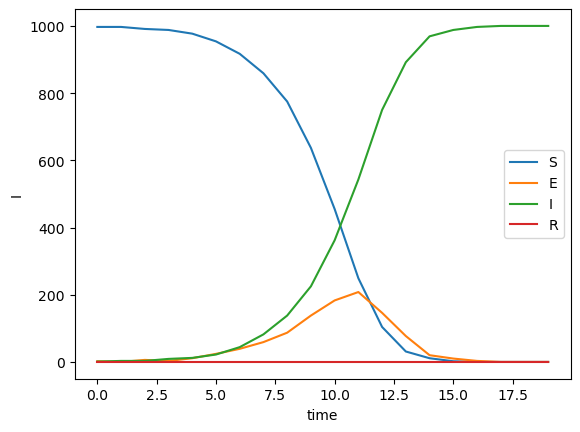

In [5]:
populationNumberPlot= realData.cpu().detach()
plt.plot(populationNumberPlot, label=['S', 'E', 'I', 'R'])
plt.xlabel("time")
plt.ylabel("I")
plt.legend()

In [60]:
realData.requires_grad_(True)
psFit= torch.tensor([[0, 0.0, 0, 0],
                     [0, 0, 0.0, 0],
                     [0, 0, 0, 0.0],
                     [0.0, 0, 0, 0]], device=device)
populationFit= epifit2.population(n, device)
modelFit= epifit2.EPI_dense(contact, psFit, populationFit, device, train=True)
lossFn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adagrad(modelFit.parameters(), lr=1e-1)

In [70]:
fitPinfs=[]
#1. choose a better optimiser
#2. add more constraint
#3. adaptive constraint?
for i in tqdm(range(500)):
    optimizer = torch.optim.Adagrad(modelFit.parameters(), lr=1e-1)
    optimizer.zero_grad()
    fitPinfs.append(modelFit.get_psMatrix())
    populationFit= epifit2.population(n, device)
    modelFit.reset_population(populationFit)
    fitPopulation, expectation = sim(timeHorizon, modelFit)
    loss = lossFn(expectation, realData)
    loss.backward(retain_graph=True)
    optimizer.step()
print(modelFit.get_psMatrix())

100%|██████████| 500/500 [00:10<00:00, 45.99it/s]

tensor([[4.0708e-11, 1.6798e-01, 2.4726e-03, 2.4726e-03],
        [2.0674e-10, 2.2737e-14, 9.2414e-01, 4.1697e-15],
        [9.3875e-18, 7.3307e-18, 1.0000e+00, 8.4520e-18],
        [1.0182e-07, 4.7502e-01, 1.0000e+00, 6.8997e-01]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


In [67]:
def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')
print_model_parameters(modelFit)

name           : _psMatrix
parameter      : Parameter containing:
tensor([[-23.9246,  -1.6000,  -5.6000,  -6.0000],
        [-16.5000, -24.8845,   2.7000, -31.5012],
        [-36.4891, -38.0392,   8.5000, -38.2428],
        [-11.7000,  -0.7000,  10.1000,   0.8000]], device='cuda:0',
       requires_grad=True)
learnable      : True
parameter.shape: torch.Size([4, 4])
parameter.grad: tensor([[ 0.0000e+00, -1.2171e+05, -8.4107e+03, -2.7612e+03],
        [ 1.0923e-02,  1.2498e-08, -1.2720e+04, -2.8227e-10],
        [ 1.5512e-10,  2.4573e-11, -5.4697e-03,  1.5357e-11],
        [ 2.6915e-02,  1.0262e+02, -1.5935e-01,  0.0000e+00]], device='cuda:0')
---------------------------------


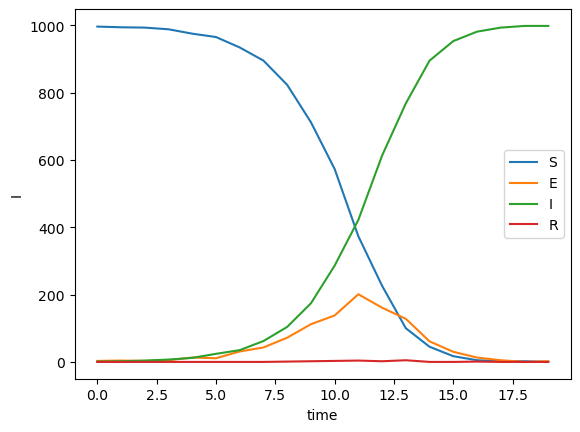

In [68]:
populationNumberPlot2= fitPopulation.cpu().detach()
plt.plot(populationNumberPlot2, label=['S', 'E', 'I', 'R'])
plt.xlabel("time")
plt.ylabel("I")
plt.legend()